In [1]:
# Necessary packages to solve the ODE's numerically
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy import integrate 

In [2]:
# Pipe material parameters
t = 0.004 # m
h = 5000 #m  
D = 0.5 #m
density = 7850

#area properties
m =  np.pi*D*t*h*density              # [kg]
I1 = 1/2*m/h*D**2
E = 210000
EI = E*I1


In [3]:
# ODE parameters
g_eff = (density - 1000)/density * 9.81
k1 = 16*EI/(h/2)**2 + 2*m*g_eff/h    # [N/m] Structural Bending stifness + tension(/gravity) stiffness
k2 = k1                                  # mass is lumped in the middle so both sides are just as stiff
c1 = 1000                               # [Ns/m] guess of damping
c2 = c1                                  # Also both damping are equal

k = k1+k2
c = c1+c2

# force parameters (necessary for analytical solution)
a_f = 10000
omega_f1 = 1/200
omega_f2 = 1/400

# parameters for analytical solution
omega_n = np.sqrt((k1+k2)/m)
zeta = (c1+c2)/(2*m*omega_n)
omega_1 = omega_n*np.emath.sqrt(1-zeta**2)


In [4]:
# Time interval
t_0 =       0       # initial time [s]
t_f =       2000    # final time [s]
dt =        0.01    # time step size [s]

tspan =     np.arange(t_0,t_f,dt)   # vector of evaluation points [s]

# Initial conditions
init_disp = 10
init_velo = 0
q_0= np.array([init_disp, init_velo])

In [5]:
# current forcing, force directly imposed on the mass
def current1(t):
    return a_f*np.sin(omega_f1*t)

# current forcing, force directly imposed on the mass
def current2(t):
    return a_f*np.sin(omega_f2*t)
    
# surface waves forcing, forced displacement of the left boundary
def waves1(t):
    return 5*np.cos(2*t)*k + -10*np.sin(2*t)*c

# functions to take into account the forcing
def f(t):
    f = 0
    for (start, stop, forcing) in event_dict.values():
        if (t >= start and t < stop):
            f += forcing(t)
    return f

In [6]:

event_dict = {
    # save events in the form: 'name':[start, stop, function]
    "current1":[0, t_f, current1],
    "current2":[0, 0, current2],
    "waves1":[0,0,waves1]
}

event_array = [
    [0, t_f, omega_f1],
    #[250, t_f, omega_f2]
]


In [7]:
# Matrix to use the displacement and velocity to obtain the acceleration
def qdot(t, q):
    q_dot =  np.array([[0,1],[-k/m, -c/m]])@q + np.array([0, f(t)/m])
    return q_dot


In [8]:
def FE(fun, tspan, y0):
    q = np.zeros((len(tspan), 2))
    q[0] = y0
    for idx, t in enumerate(tspan[:-1]):
        q_dot_i = fun(t, q[idx])
        q[idx+1] = q[idx] + dt*q_dot_i
    return q


In [9]:
def get_an_solution(tspan, y0, omega_f):
    x0, v0 = y0[0], y0[1]

    x = 2*m**2*(((m**2*x0*omega_f**4 + x0*(c**2 - 2*k*m)*omega_f**2 + c*a_f*omega_f + k**2*x0)*np.emath.sqrt(c**2 - 4*k*m) \
        + (c*m**2*x0 + 2*m**3*v0)*omega_f**4 + 2*m**2*a_f*omega_f**3 + (c*x0 + 2*m*v0)*(c**2 - 2*k*m)*omega_f**2 \
        + a_f*(c**2 - 2*k*m)*omega_f + k**2*(c*x0 + 2*m*v0))*np.exp(((-c + np.emath.sqrt(c**2 - 4*k*m))*tspan)/(2*m)) + ((m**2*x0*omega_f**4 + x0*(c**2 - 2*k*m)*omega_f**2 \
        + c*a_f*omega_f + k**2*x0)*np.emath.sqrt(c**2 - 4*k*m) + (-c*m**2*x0 - 2*m**3*v0)*omega_f**4 - 2*m**2*a_f*omega_f**3 \
        - (c*x0 + 2*m*v0)*(c**2 - 2*k*m)*omega_f**2 - a_f*(c**2 - 2*k*m)*omega_f - k**2*(c*x0 + 2*m*v0))*np.exp(-((c + np.emath.sqrt(c**2 - 4*k*m))*tspan)/(2*m)) - 2*a_f*((m*omega_f**2 - k)*np.sin(omega_f*tspan) \
        + np.cos(omega_f*tspan)*c*omega_f)*np.emath.sqrt(c**2 - 4*k*m))/(np.emath.sqrt(c**2 - 4*k*m)*(2*omega_f**2*m**2 + c*np.emath.sqrt(c**2 - 4*k*m) + c**2 - 2*k*m)*(2*omega_f**2*m**2 - c*np.emath.sqrt(c**2 - 4*k*m) + c**2 - 2*k*m))

    _C1 =-m*((-m*x0*omega_f**2 + c*v0 + k*x0)*np.emath.sqrt(c**2 - 4*k*m) + 2*m**2*v0*omega_f**2 + (c*x0*omega_f**2 - 2*k*v0 + 2*a_f*omega_f)*m + c**2*v0 + c*k*x0)/(np.emath.sqrt(c**2 - 4*k*m)*(2*omega_f**2*m**2 + c*np.emath.sqrt(c**2 - 4*k*m) + c**2 - 2*k*m))
    _C2 = m*((m*x0*omega_f**2 - c*v0 - k*x0)*np.emath.sqrt(c**2 - 4*k*m) + 2*m**2*v0*omega_f**2 + (c*x0*omega_f**2 - 2*k*v0 + 2*a_f*omega_f)*m + c**2*v0 + c*k*x0)/(np.emath.sqrt(c**2 - 4*k*m)*(2*omega_f**2*m**2 - c*np.emath.sqrt(c**2 - 4*k*m) + c**2 - 2*k*m))
    
    v= ((-c + np.emath.sqrt(c**2 - 4*k*m))*np.exp(((-c + np.emath.sqrt(c**2 - 4*k*m))*tspan)/(2*m))*_C2)/(2*m) \
    - ((c + np.emath.sqrt(c**2 - 4*k*m))*np.exp(-((c + np.emath.sqrt(c**2 - 4*k*m))*tspan)/(2*m))*_C1)/(2*m) - a_f*(omega_f**3*np.cos(omega_f*tspan)*m - omega_f**2*np.sin(omega_f*tspan)*c - omega_f*np.cos(omega_f*tspan)*k)/(m**2*omega_f**4 + c**2*omega_f**2 - 2*k*m*omega_f**2 + k**2)
    
    return np.real(x), np.real(v)


def get_an_event_solution(event_array, y0):
    x, v = [], []
    
    for (start, stop, omega_f) in event_array:
        tspan = np.arange(start,stop,dt)
        x_next, v_next = get_an_solution(tspan, y0, omega_f)
        x.extend(x_next)
        v.extend(v_next)
        y0 = [x[-1], v[-1]]
    
    return np.array(x), np.array(v)
    


In [10]:
def q_ddot_approx(q_dot_n, q_dot_nm1, dt):
    q_ddot_n = (q_dot_n - q_dot_nm1)/dt
    return q_ddot_n
    

def FE_variable_t(fun, q_0, t_0, t_f, dt_0=100, eps_abs=0.01, eps_rel=0.1, var_factor=1):
    timestep_configured = False
    # Find appropriate timestep size to start with
    i = 0
    while not timestep_configured:
        # 1. Compute the first iteration of the numerical scheme with an arbitrarily small timestep
        q_dot_0 = fun(t_0, q_0)
        q_1 = q_0 + dt_0*q_dot_0
        
        # 2. Compute the proportional treshold $\tau = \epsilon_{rel}|q|$ and check if it is smaller than the absolute maximum $\epsilon_{abs}$.
        tau_rel = eps_rel * min([abs(i) for i in q_1])
        
        # 3 If not, $\Delta t_new = \frac{1}{2}\Delta t_old$ and start at step 1, else continue to step 4. 
        if tau_rel < eps_abs:
            timestep_configured = True
            print("Time step configured to: ", dt_0, "s")
        else:
            if i == 0:
                print("WARNING - Initial step size badly configured, adjusting the size to conform to the given tresholds eps_abs and eps_rel")
                i=1
            dt_0 = 0.5*dt_0

    # 4*. Compute an approximation for $\ddot{q}$ based on the computed state variable $\dot{q}$.
    # Note that this approximation based on $\dot{q}_1$ is only meant for $\ddot{q}_0$
    q_dot_1 = fun(dt_0, q_1)
    q_dot_nm1 = q_dot_1
    dt_n = dt_0
    
    q = []
    t = []
    t_n = t_0
    q_n = q_0
    while t_n < t_f:
        # Store time
        t.append(t_n)
        q.append(q_n)
        
        q_dot_n = fun(t_n, q_n)
        
        # 4. Compute an approximation for $\ddot{q}$ based on the computed state variable $\dot{q}$.
        q_ddot_n =  q_ddot_approx(q_dot_n, q_dot_nm1, dt_n)
        
        # 5. Compute the time step size based on $\ddot{q}$ and run the numerical scheme.
        tau = max(eps_rel*min([abs(i) for i in q_n]), eps_abs)
        dt_tau = np.sqrt(2*tau/min([abs(i) for i in q_ddot_n]))
        dt_n = (dt_n + dt_tau*var_factor) / (var_factor + 1)
         
        # 6. Compute value of $q_{n+1}$
        q_n = q_n + dt_n * q_dot_n
        
        # Save $\ddot{q}_{n-1}$ for next iteration
        q_dot_nm1 = q_dot_n
        
        # Increase time by dt_n
        t_n += dt_n
        
    return np.array(q),np.array(t)


In [11]:
sol = solve_ivp(qdot,(t_0, t_f),q_0, t_eval=tspan, method='RK45', dense_output=True)

FE_sol = FE(qdot,tspan,q_0)

#an_sol = get_an_solution(tspan, q_0, omega_f1)
an_sol = get_an_event_solution(event_array, q_0)


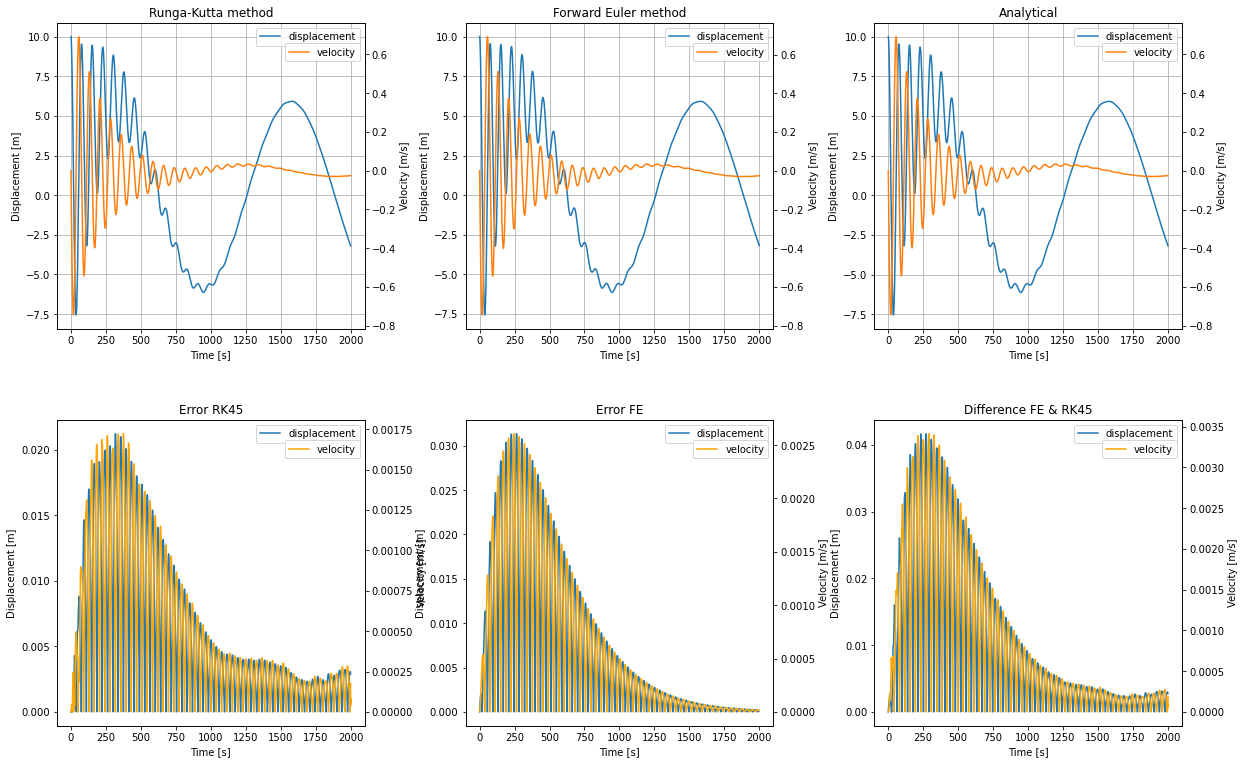

In [12]:
fig, axes = plt.subplots(2,3, figsize=(18,12))
fig.tight_layout(pad=7.0)
ax1, ax2, ax3 = axes[0]
ax4, ax5, ax6 = axes[1]

# Runga Kutta
ax1.plot(sol.t,sol.y[0], label='displacement')
ax1.set_ylabel('Displacement [m]')
ax12 = ax1.twinx()
ax12.plot(sol.t,sol.y[1], 'tab:orange', label='velocity')
ax12.set_ylabel('Velocity [m/s]')
ax1.set_xlabel('Time [s]')
ax1.grid()
ax1.set_title('Runga-Kutta method')
ax1.legend()
ax12.legend(bbox_to_anchor=(1, 0.95))

# Forward Euler
ax2.plot(tspan,FE_sol[:, 0], label='displacement')
ax2.set_ylabel('Displacement [m]')
ax21 = ax2.twinx()
ax21.plot(tspan, FE_sol[:, 1], 'tab:orange', label='velocity')
ax21.set_ylabel('Velocity [m/s]')
ax2.set_xlabel('Time [s]');
ax2.grid()
ax2.set_title('Forward Euler method')
ax2.legend()
ax21.legend(bbox_to_anchor=(1, 0.95))


# Analytical
ax3.plot(tspan, an_sol[0], label='displacement')
ax3.set_ylabel('Displacement [m]')
ax31 = ax3.twinx()
ax31.plot(tspan, an_sol[1], 'tab:orange', label='velocity')
ax31.set_ylabel('Velocity [m/s]')
ax3.set_xlabel('Time [s]');
ax3.grid()
ax3.set_title('Analytical')
ax3.legend()
ax31.legend(bbox_to_anchor=(1, 0.95))


# RK45 error
ax4.plot(tspan, abs(an_sol[0]-sol.y[0]), label='displacement')
ax4.set_ylabel('Displacement [m]')
ax41 = ax4.twinx()
ax41.plot(tspan, abs(an_sol[1]-sol.y[1]), 'orange', label='velocity')
ax41.set_ylabel('Velocity [m/s]')
ax4.set_xlabel('Time [s]');
ax4.set_title('Error RK45')
ax4.legend()
ax41.legend(bbox_to_anchor=(1, 0.95))


# FE error
ax5.plot(tspan,abs(an_sol[0]-FE_sol[:,0]), label='displacement')
ax5.set_ylabel('Displacement [m]')
ax51 = ax5.twinx()
ax51.set_ylabel('Velocity [m/s]')
ax51.plot(tspan,abs(an_sol[1]-FE_sol[:,1]), 'orange', label='velocity')
ax5.set_xlabel('Time [s]');
ax5.set_title('Error FE')
ax5.legend()
ax51.legend(bbox_to_anchor=(1, 0.95))


# Difference FE & RK45
ax6.plot(tspan,abs(FE_sol[:,0]-sol.y[0]), label='displacement')
ax6.set_ylabel('Displacement [m]')
ax61 = ax6.twinx()
ax61.plot(tspan,abs(FE_sol[:,1]-sol.y[1]), 'orange', label='velocity')
ax61.set_ylabel('Velocity [m/s]')
ax6.set_xlabel('Time [s]');
ax6.set_title('Difference FE & RK45')
ax6.legend()
ax61.legend(bbox_to_anchor=(1, 0.95))


plt.show()


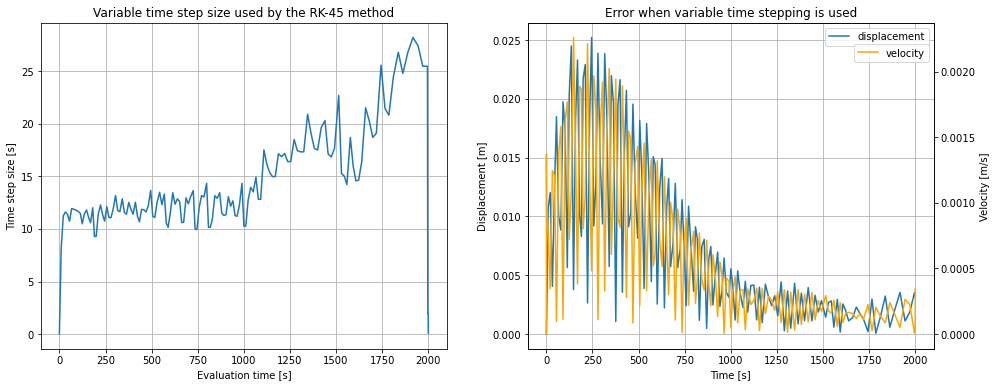

In [13]:
sol2 = solve_ivp(qdot,(t_0, t_f),q_0, method='RK45', dense_output=True)
timesteps = np.round(np.diff(sol2.t),9)

fig,(ax1,ax2) =plt.subplots(1,2, figsize=(16,6))
ax1.plot(sol2.t[1:], timesteps)
ax1.set_title("Variable time step size used by the RK-45 method")
ax1.set_xlabel('Evaluation time [s]')
ax1.set_ylabel('Time step size [s]')
ax1.grid()


index = [max(int(i-1),0) for i in sol2.t/dt]
sol_slice_displacement = an_sol[0][index]
sol_slice_velocity = an_sol[1][index]

ax2.plot(sol2.t,abs(sol_slice_displacement - sol2.y[0]), label='displacement')
ax2.set_ylabel('Displacement [m]')
ax21 = ax2.twinx()
ax21.plot(sol2.t,abs(sol_slice_velocity - sol2.y[1]), 'orange', label='velocity')
ax21.set_ylabel('Velocity [m/s]')
ax2.set_xlabel('Time [s]');
ax2.set_title('Error when variable time stepping is used')
ax2.legend()
ax2.grid()
ax21.legend(bbox_to_anchor=(1, 0.95))




WARNING - Initial step size badly configured, adjusting the size to conform to the given tresholds eps_abs and eps_rel
Time step configured to:  0.09765625 s


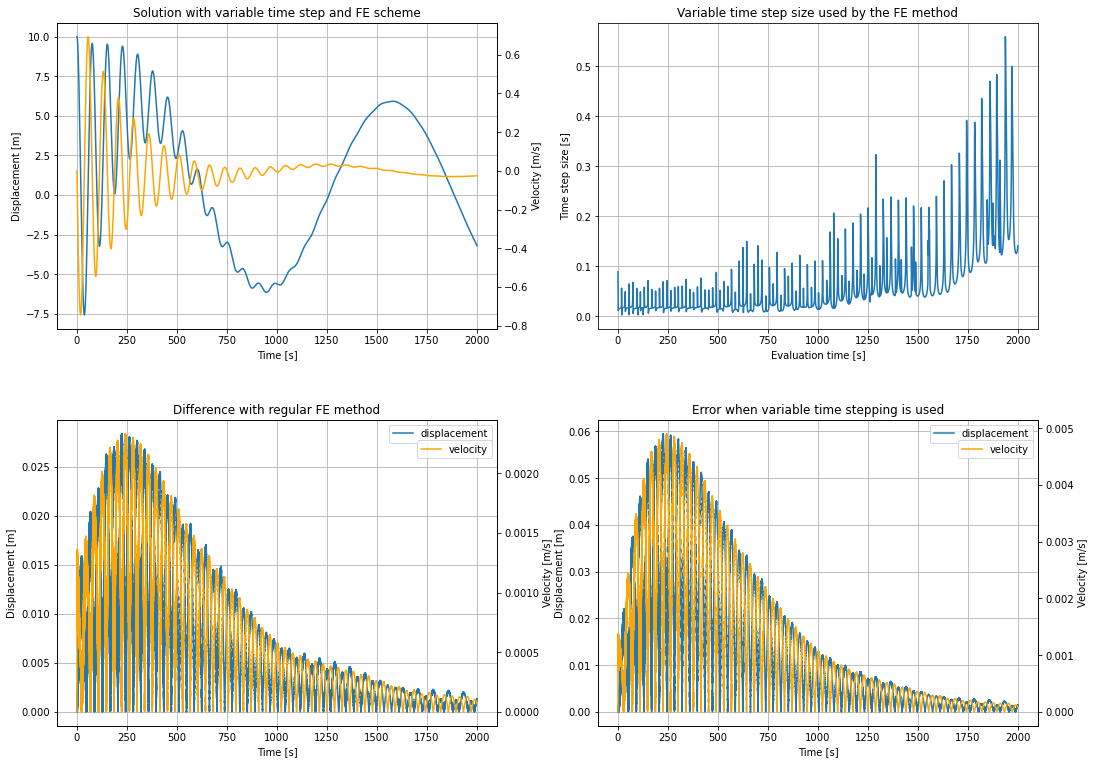

In [14]:
FE_var_t_sol, FE_var_t = FE_variable_t(qdot, q_0, t_0, t_f, eps_rel=0.000001, eps_abs=0.00000001, var_factor=.1)

timesteps = np.round(np.diff(FE_var_t),9)

fig, [[ax3, ax1],[ax4,ax2]] = plt.subplots(2,2, figsize=(16,12))
fig.tight_layout(pad=7.0)

ax3.plot(FE_var_t, FE_var_t_sol[:,0], label='displacement')
ax3.set_title("Solution with variable time step and FE scheme")
ax3.set_xlabel('Time [s]')
ax3.set_ylabel('Displacement [m]')
ax31 = ax3.twinx()
ax31.plot(FE_var_t,FE_var_t_sol[:,1], 'orange', label='velocity')
ax31.set_ylabel('Velocity [m/s]')
ax3.grid()

ax1.plot(FE_var_t[1:], timesteps)
ax1.set_title("Variable time step size used by the FE method")
ax1.set_xlabel('Evaluation time [s]')
ax1.set_ylabel('Time step size [s]')
ax1.grid()

an_dt = 0.01
index = [min(max(int(i-1),0), int(t_f/an_dt-1)) for i in FE_var_t/an_dt]

an_sol_slice_displacement = an_sol[0][index]
an_sol_slice_velocity = an_sol[1][index]

FE_sol_slice_displacement = FE_sol[index,0]
FE_sol_slice_velocity = FE_sol[index,1]

ax2.plot(FE_var_t,abs(an_sol_slice_displacement - FE_var_t_sol[:,0]), label='displacement')
ax2.set_ylabel('Displacement [m]')
ax21 = ax2.twinx()
ax21.plot(FE_var_t,abs(an_sol_slice_velocity - FE_var_t_sol[:,1]), 'orange', label='velocity')
ax21.set_ylabel('Velocity [m/s]')
ax2.set_xlabel('Time [s]');
ax2.set_title('Error when variable time stepping is used')
ax2.legend()
ax2.grid()
ax21.legend(bbox_to_anchor=(1, 0.95))

ax4.plot(FE_var_t,abs(FE_sol_slice_displacement - FE_var_t_sol[:,0]), label='displacement')
ax4.set_ylabel('Displacement [m]')
ax41 = ax4.twinx()
ax41.plot(FE_var_t,abs(FE_sol_slice_velocity - FE_var_t_sol[:,1]), 'orange', label='velocity')
ax41.set_ylabel('Velocity [m/s]')
ax4.set_xlabel('Time [s]');
ax4.set_title('Difference with regular FE method')
ax4.legend()
ax4.grid()
ax41.legend(bbox_to_anchor=(1, 0.95))